<a href="https://colab.research.google.com/github/SovetovAleksey/Numpy-Pandas-Matplotlib-Scikit-learn/blob/Second_project/Sovetov_ALeksey_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <center>Курсовой проект<a class="anchor" id="course_project"></a><center>

### Постановка задачи<a class="anchor" id="course_project_task"></a>

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара.
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества.
Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

### Примерное описание этапов выполнения курсового проекта<a class="anchor" id="course_project_steps"></a>

**Построение модели классификации**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

### Обзор данных<a class="anchor" id="course_project_review"></a>

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [ ]:
pip install catboost

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

In [ ]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [ ]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [ ]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [ ]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [ ]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [ ]:
np.random.seed(42)

**Пути к директориям и файлам**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
TRAIN_DATASET_PATH = '/content/gdrive/MyDrive/Продолжение/Курсач/course_project_train.csv'
TEST_DATASET_PATH = '/content/gdrive/MyDrive/Продолжение/Курсач/course_project_test.csv'

**Загрузка данных**

In [ ]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [ ]:
df_train.shape

(7500, 17)

In [ ]:
df_train.iloc[0]

Home Ownership                            Own Home
Annual Income                             482087.0
Years in current job                           NaN
Tax Liens                                      0.0
Number of Open Accounts                       11.0
Years of Credit History                       26.3
Maximum Open Credit                       685960.0
Number of Credit Problems                      1.0
Months since last delinquent                   NaN
Bankruptcies                                   1.0
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                     99999999.0
Current Credit Balance                     47386.0
Monthly Debt                                7914.0
Credit Score                                 749.0
Credit Default                                   0
Name: 0, dtype: object

In [ ]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [ ]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [ ]:
df_test.shape

(2500, 16)

### Обработка выбросов<a class="anchor" id="course_project_review"></a>

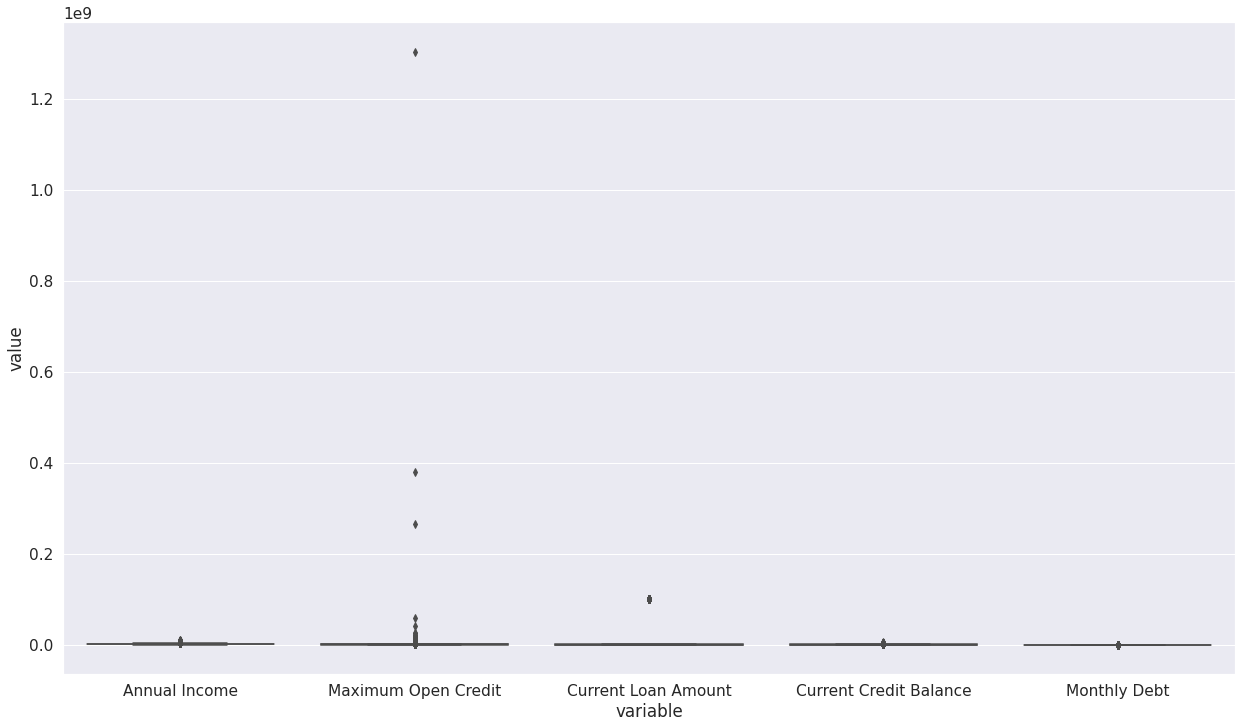

In [ ]:
box_df = pd.DataFrame(data = df_train, columns = ['Annual Income', 'Maximum Open Credit', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt'])
plt.figure(figsize = (21, 12))
sns.boxplot(x = 'variable', y = 'value', data = pd.melt(box_df))
plt.show()

**Maximum Open Credit**

In [ ]:
df_train.loc[df_train['Maximum Open Credit'] >= 8000000, 'Maximum Open Credit'] = df_train['Maximum Open Credit'].median()
df_train['Maximum Open Credit outlier'] = 0
df_train.loc[(df_train['Maximum Open Credit'] > df_train['Maximum Open Credit'].quantile(0.975)), 'Maximum Open Credit outlier'] = 1

**Current Loan Amount**

In [ ]:
df_train.loc[df_train['Current Loan Amount'] >= 20000000, 'Current Loan Amount'] = df_train['Current Loan Amount'].median()
df_train['Current Loan Amount outlier'] = 0
df_train.loc[(df_train['Current Loan Amount'] > df_train['Current Loan Amount'].quantile(0.975)), 'Current Loan Amount outlier'] = 1

**Annual Income**

In [ ]:
df_train.loc[df_train['Annual Income'] >= 10000000, 'Annual Income'] = df_train['Annual Income'].median()
df_train['Annual Income outlier'] = 0
df_train.loc[(df_train['Annual Income'] > df_train['Annual Income'].quantile(0.975)), 'Annual Income outlier'] = 1

**Current Credit Balance**

In [ ]:
df_train.loc[df_train['Current Credit Balance'] >= 3000000, 'Current Credit Balance'] = df_train['Current Credit Balance'].median()
df_train['Current Credit Balance outlier'] = 0
df_train.loc[(df_train['Current Credit Balance'] > df_train['Current Credit Balance'].quantile(0.975)), 'Current Credit Balance outlier'] = 1

**Years of Credit History**

In [ ]:
df_train.loc[df_train['Years of Credit History'] >= 55, 'Years of Credit History'] = df_train['Years of Credit History'].median()
df_train['Years of Credit History outlier'] = 0
df_train.loc[(df_train['Years of Credit History'] > df_train['Years of Credit History'].quantile(0.975)), 'Years of Credit History outlier'] = 1

**Months since last delinquent**

In [ ]:
df_train.loc[df_train['Months since last delinquent'] >= 100, 'Months since last delinquent'] = df_train['Months since last delinquent'].median()
df_train['Months since last delinquent outlier'] = 0
df_train.loc[(df_train['Months since last delinquent'] > df_train['Months since last delinquent'].quantile(0.975)), 'Months since last delinquent outlier'] = 1

**Monthly Debt**

In [ ]:
df_train.loc[df_train['Monthly Debt'] >= 100000, 'Monthly Debt'] = df_train['Monthly Debt'].median()
df_train['Monthly Debt outlier'] = 0
df_train.loc[(df_train['Monthly Debt'] > df_train['Monthly Debt'].quantile(0.975)), 'Monthly Debt outlier'] = 1

**Credit Score**

In [ ]:
df_train.loc[df_train['Credit Score'] >= 6000, 'Credit Score'] = df_train['Credit Score'].median()
df_train['Credit Score outlier'] = 0
df_train.loc[(df_train['Credit Score'] > df_train['Credit Score'].quantile(0.975)), 'Credit Score outlier'] = 1

**Large Score**

In [ ]:
df_train['Large Score'] = 0
df_train.loc[df_train['Credit Score']>1000, 'Large Score'] = 1
df_train['Large Score'].value_counts()

0    7500
Name: Large Score, dtype: int64

Результат

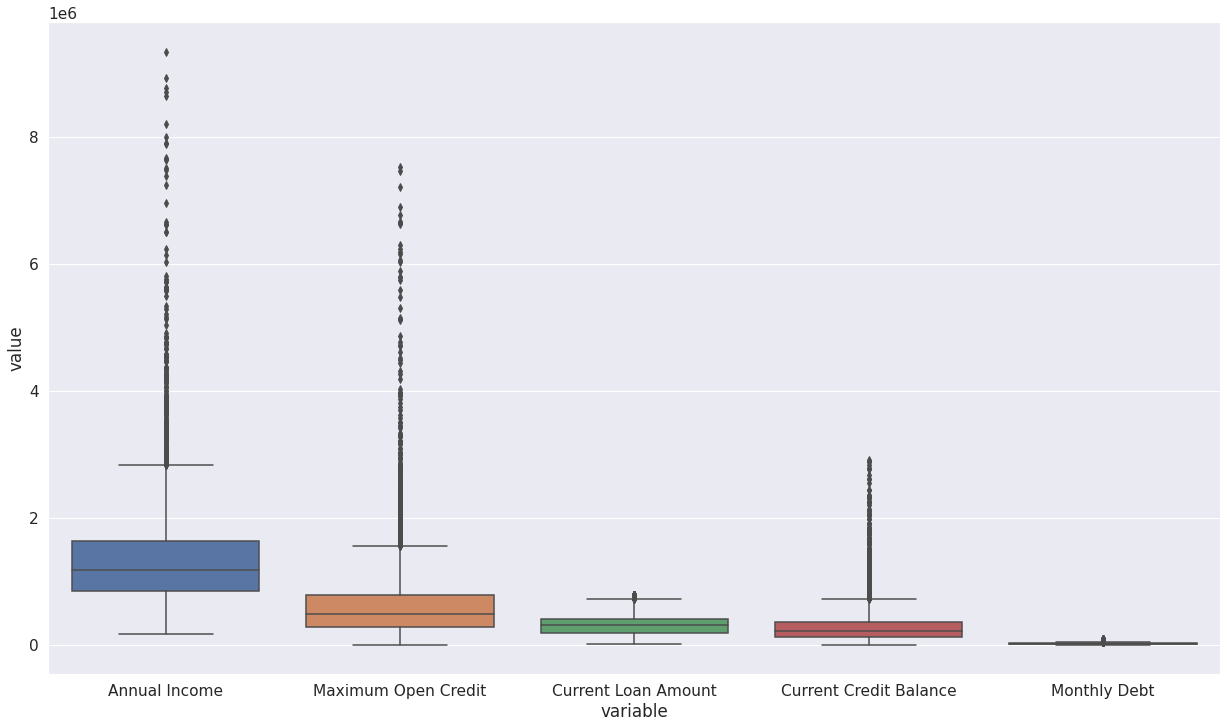

In [ ]:
box_df = pd.DataFrame(data = df_train, columns = ['Annual Income', 'Maximum Open Credit', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt'])
plt.figure(figsize = (21, 12))
sns.boxplot(x = 'variable', y = 'value', data = pd.melt(box_df))
plt.show()

### Обработка пропусков<a class="anchor" id="course_project_review"></a>

In [ ]:
df_train.isna().sum()

Home Ownership                             0
Annual Income                           1557
Years in current job                     371
Tax Liens                                  0
Number of Open Accounts                    0
Years of Credit History                    0
Maximum Open Credit                        0
Number of Credit Problems                  0
Months since last delinquent            4081
Bankruptcies                              14
Purpose                                    0
Term                                       0
Current Loan Amount                        0
Current Credit Balance                     0
Monthly Debt                               0
Credit Score                            1557
Credit Default                             0
Maximum Open Credit outlier                0
Current Loan Amount outlier                0
Annual Income outlier                      0
Current Credit Balance outlier             0
Years of Credit History outlier            0
Months sin

In [ ]:
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Credit Default,Maximum Open Credit outlier,Current Loan Amount outlier,Annual Income outlier,Current Credit Balance outlier,Years of Credit History outlier,Months since last delinquent outlier,Monthly Debt outlier,Credit Score outlier,Large Score
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,...,0,0,0,0,0,0,0,0,0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,...,1,0,0,0,0,0,0,0,0,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,...,0,0,0,0,0,0,0,0,0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,...,0,0,0,0,0,0,0,0,0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_train['Annual Income'].fillna(df_train['Annual Income'].median(), inplace = True)
df_train['Months since last delinquent'].fillna(df_train['Months since last delinquent'].median(), inplace = True)
df_train['Years in current job'].fillna('10+ years', inplace = True)
df_train['Bankruptcies'].fillna('0.0', inplace = True)
df_train['Credit Score'].fillna(df_train['Credit Score'].median(), inplace = True)

In [ ]:
df_train.isna().sum() 

Home Ownership                          0
Annual Income                           0
Years in current job                    0
Tax Liens                               0
Number of Open Accounts                 0
Years of Credit History                 0
Maximum Open Credit                     0
Number of Credit Problems               0
Months since last delinquent            0
Bankruptcies                            0
Purpose                                 0
Term                                    0
Current Loan Amount                     0
Current Credit Balance                  0
Monthly Debt                            0
Credit Score                            0
Credit Default                          0
Maximum Open Credit outlier             0
Current Loan Amount outlier             0
Annual Income outlier                   0
Current Credit Balance outlier          0
Years of Credit History outlier         0
Months since last delinquent outlier    0
Monthly Debt outlier              

### Анализ целевой переменной<a class="anchor" id="course_project_review"></a>

**Выделение целевой переменной**

In [ ]:
df_base = pd.read_csv(TRAIN_DATASET_PATH)

In [ ]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_base.columns.drop([TARGET_NAME]).tolist()
NEW_FEATURE_NAMES = df_train.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES).tolist()

**Обзор распределения**

In [ ]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

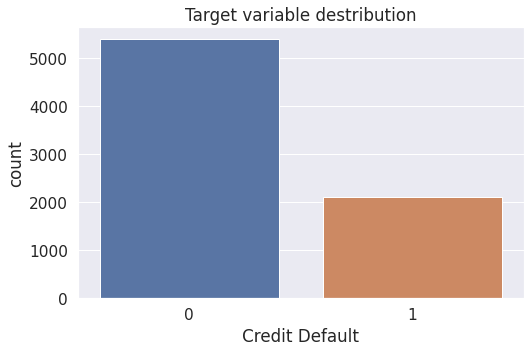

In [ ]:
plt.figure(figsize=(8, 5))

sns.countplot(x = df_train['Credit Default'], data = df_train)

plt.title('Target variable destribution')
plt.show()

**Корреляция с базовыми признаками**

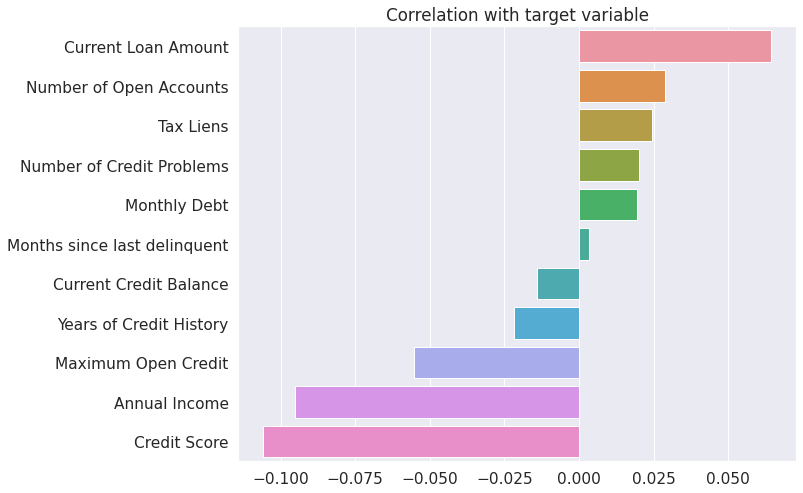

In [ ]:
corr_with_target = df_train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

### Анализ признакового пространства<a class="anchor" id="course_project_review"></a>

**Матрица корреляций**

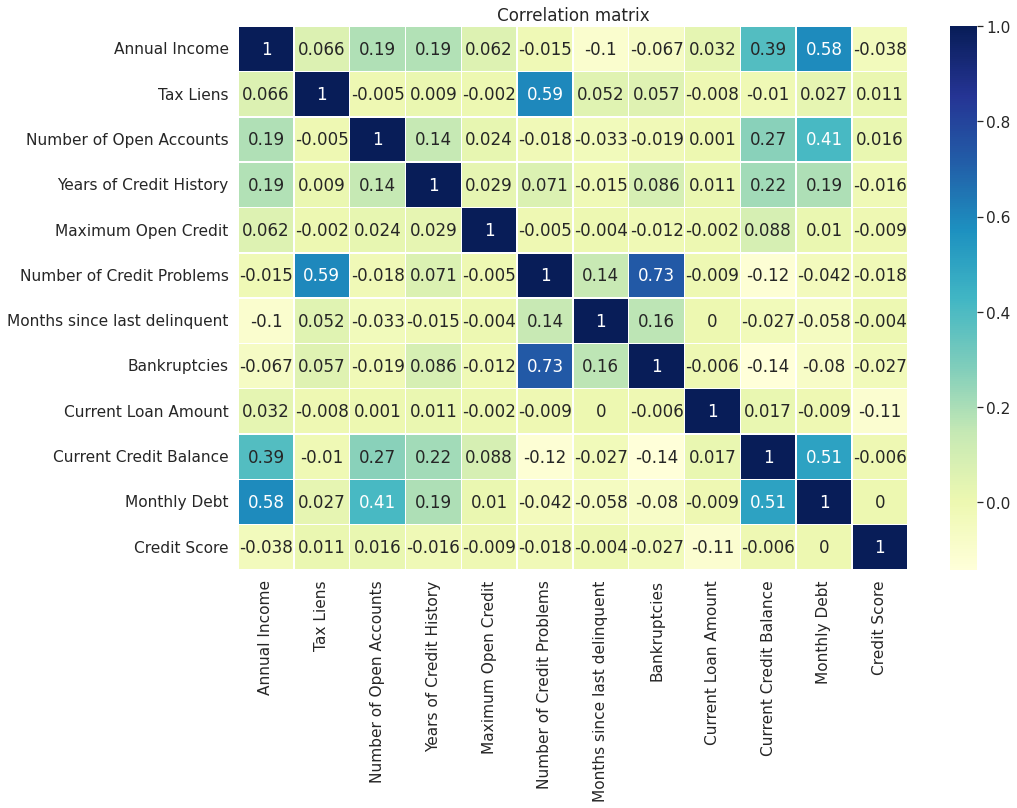

In [ ]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = df_base[BASE_FEATURE_NAMES].corr()
corr_matrix = np.round(corr_matrix, 3)

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='YlGnBu')

plt.title('Correlation matrix')
plt.show()

### Отбор признаков<a class="anchor" id="course_project_review"></a>

In [ ]:
NUM_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems',
                     'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount',
                     'Current Credit Balance', 'Monthly Debt', 'Credit Score']

CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term', 'Large Score']

SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + NEW_FEATURE_NAMES

In [ ]:
df_train[SELECTED_FEATURE_NAMES]

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,...,Credit Score,Maximum Open Credit outlier,Current Loan Amount outlier,Annual Income outlier,Current Credit Balance outlier,Years of Credit History outlier,Months since last delinquent outlier,Monthly Debt outlier,Credit Score outlier,Large Score
0,482087.0,0.0,11.0,26.3,685960.0,1.0,32.0,1.0,309573.0,47386.0,...,749.0,0,0,0,0,0,0,0,0,0
1,1025487.0,0.0,15.0,15.3,1181730.0,0.0,32.0,0.0,264968.0,394972.0,...,737.0,0,0,0,0,0,0,0,0,0
2,751412.0,0.0,11.0,35.0,1182434.0,0.0,32.0,0.0,309573.0,308389.0,...,742.0,0,0,0,0,0,0,0,0,0
3,805068.0,0.0,8.0,22.5,147400.0,1.0,32.0,1.0,121396.0,95855.0,...,694.0,0,0,0,0,0,0,0,0,0
4,776264.0,0.0,13.0,13.6,385836.0,1.0,32.0,0.0,125840.0,93309.0,...,719.0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,402192.0,0.0,3.0,8.5,107866.0,0.0,32.0,0.0,129360.0,73492.0,...,697.0,0,0,0,0,0,0,0,0,0
7496,1533984.0,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,444048.0,456399.0,...,731.0,0,0,0,0,0,0,0,0,0
7497,1878910.0,0.0,12.0,32.1,1778920.0,0.0,32.0,0.0,309573.0,477812.0,...,748.0,0,0,0,0,0,0,0,0,0
7498,1168386.0,0.0,21.0,26.5,1141250.0,0.0,32.0,0.0,615274.0,476064.0,...,731.0,0,0,0,0,0,0,0,0,0


### Приведение типов для модели CatBoost

In [ ]:
for colname in CAT_FEATURE_NAMES:
    df_train[colname] = pd.Categorical(df_train[colname])
    
df_train[CAT_FEATURE_NAMES].dtypes

Home Ownership          category
Years in current job    category
Purpose                 category
Term                    category
Large Score             category
dtype: object

### Нормализация данных<a class="anchor" id="normalization"></a>

In [ ]:
#scaler = StandardScaler()

#df_norm = df_train.copy()
#df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

#df_train = df_norm.copy()

### Разбиение на train и test<a class="anchor" id="train_and_test"></a>

In [ ]:
X = df_train[SELECTED_FEATURE_NAMES]
y = df_train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

### Балансировка целевой переменной<a class="anchor" id="target_balancing"></a>

In [ ]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    3771
1    2958
Name: Credit Default, dtype: int64

In [ ]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

### Сохранение обучающего и тестового датасетов<a class="anchor" id="train_test_saving"></a> 

In [ ]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [ ]:
df_train.to_csv('df_train_prep', index=False, encoding='utf-8')
train.to_csv('train', index=False, encoding='utf-8')
test.to_csv('test', index=False, encoding='utf-8')

### Построение и оценка базовых моделей<a class="anchor" id="baseline_modeling"></a> 

*CatBoost*

In [ ]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train, cat_features = ['Large Score'])

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      3771
           1       0.90      0.85      0.88      2958

    accuracy                           0.89      6729
   macro avg       0.90      0.89      0.89      6729
weighted avg       0.89      0.89      0.89      6729

TEST

              precision    recall  f1-score   support

           0       0.80      0.81      0.80      1616
           1       0.50      0.48      0.49       634

    accuracy                           0.72      2250
   macro avg       0.65      0.65      0.65      2250
weighted avg       0.71      0.72      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1306  310
1                328  306


### Выбор лучшей модели и подбор гиперпараметров<a class="anchor" id="tuning_best_model"></a> 

In [ ]:
model_catb = catb.CatBoostClassifier(class_weights=[1, 3.5], silent=True, random_state=21, cat_features = ['Large Score'])

**Подбор гиперпараметров**

In [ ]:
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500],
          'max_depth':[3, 5, 7]}

In [ ]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [ ]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)

CPU times: user 861 ms, sys: 114 ms, total: 975 ms
Wall time: 58.9 s


In [ ]:
rs.best_params_

{'max_depth': 3, 'n_estimators': 100}

In [ ]:
rs.best_score_

0.5281420901819578

**Обучение и оценка финальной модели**

In [ ]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=100, max_depth=3,
                                      silent=True, random_state=21, cat_features = ['Large Score'])
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.76      0.81      0.78      3771
           1       0.73      0.67      0.70      2958

    accuracy                           0.75      6729
   macro avg       0.74      0.74      0.74      6729
weighted avg       0.75      0.75      0.75      6729

TEST

              precision    recall  f1-score   support

           0       0.82      0.76      0.79      1616
           1       0.48      0.56      0.52       634

    accuracy                           0.71      2250
   macro avg       0.65      0.66      0.65      2250
weighted avg       0.72      0.71      0.71      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1236  380
1                278  356
CPU times: user 355 ms, sys: 34.2 ms, total: 389 ms
Wall time: 250 ms


### Снижение степени переобучения<a class="anchor" id="lowering_overfitting"></a>

In [ ]:
final_model = catb.CatBoostClassifier(n_estimators=500, max_depth=3,
                                      l2_leaf_reg=10,
                                      silent=True, random_state=21, cat_features = ['Large Score'])
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.74      0.80      0.77      3771
           1       0.72      0.65      0.68      2958

    accuracy                           0.73      6729
   macro avg       0.73      0.72      0.73      6729
weighted avg       0.73      0.73      0.73      6729

TEST

              precision    recall  f1-score   support

           0       0.82      0.76      0.79      1616
           1       0.48      0.56      0.52       634

    accuracy                           0.70      2250
   macro avg       0.65      0.66      0.65      2250
weighted avg       0.72      0.70      0.71      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1226  390
1                276  358


### Подбор оптимального размера выборки, кривая обучения<a class="anchor" id="learning_curve"></a>

In [ ]:
final_model = catb.CatBoostClassifier(n_estimators=500, max_depth=3,
                                      class_weights=[1, 3.5],
                                      silent=True, random_state=21, cat_features = ['Large Score'])

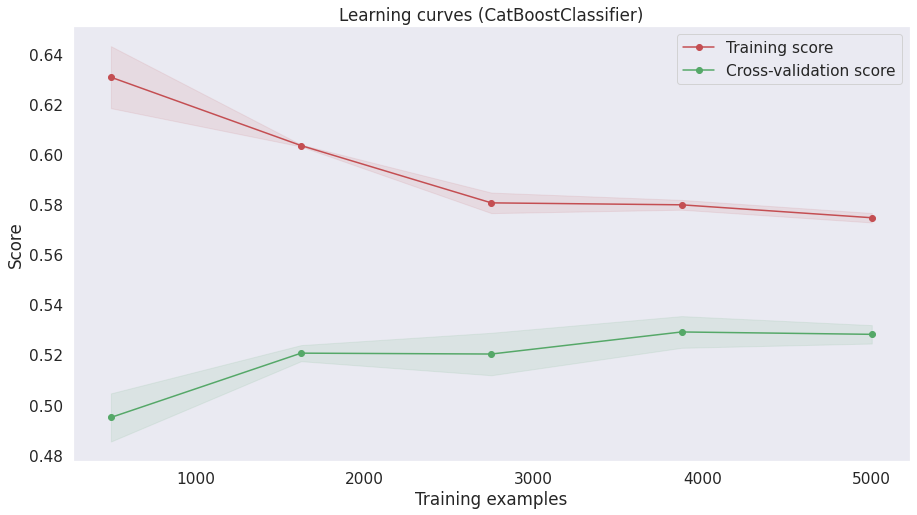

In [ ]:
show_learning_curve_plot(final_model, X, y)

### Выбор порога вероятности для определения класса<a class="anchor" id="threshold_calibration"></a>

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


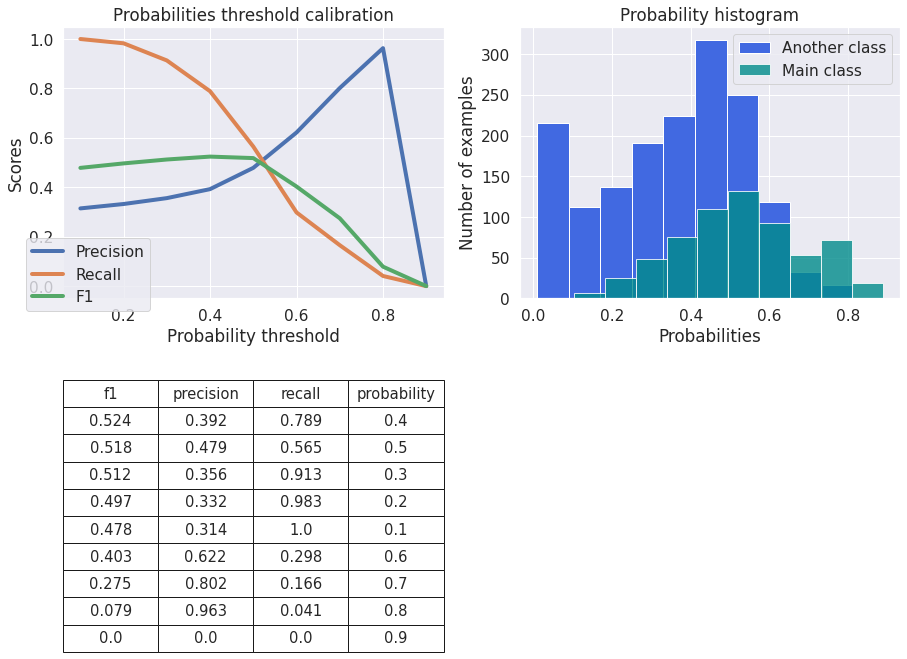

In [ ]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

### Важность признаков<a class="anchor" id="feature_importances"></a>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


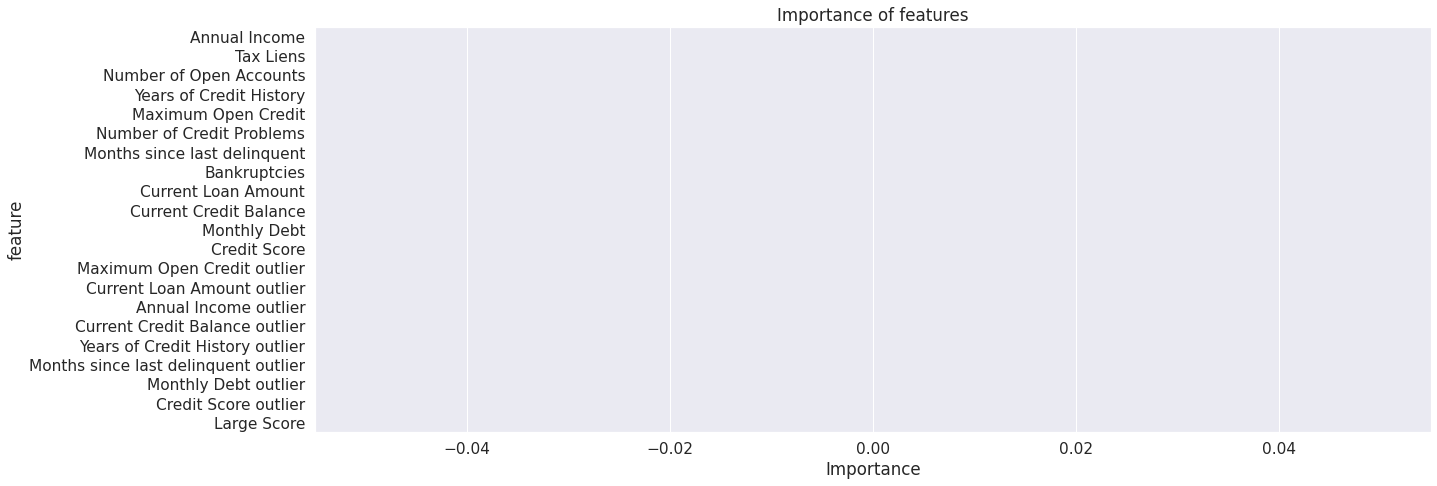

In [ ]:
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=21)

In [ ]:
important_features_top

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Maximum Open Credit outlier',
 'Current Loan Amount outlier',
 'Annual Income outlier',
 'Current Credit Balance outlier',
 'Years of Credit History outlier',
 'Months since last delinquent outlier',
 'Monthly Debt outlier',
 'Credit Score outlier',
 'Large Score']

In [ ]:
df_train['Large Score'].value_counts()

0    7500
Name: Large Score, dtype: int64

### Финальная модель<a class="anchor" id="final_model"></a>

In [ ]:
final_model = catb.CatBoostClassifier(n_estimators=500, max_depth=3, l2_leaf_reg=10,
                                      silent=True, random_state=21, cat_features = ['Large Score'])
final_model.fit(X_train[important_features_top], y_train)

y_train_pred = final_model.predict(X_train[important_features_top])
y_test_pred = final_model.predict(X_test[important_features_top])
y_test_pred_probs = final_model.predict_proba(X_test[important_features_top])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.74      0.80      0.77      3771
           1       0.72      0.65      0.68      2958

    accuracy                           0.73      6729
   macro avg       0.73      0.72      0.73      6729
weighted avg       0.73      0.73      0.73      6729

TEST

              precision    recall  f1-score   support

           0       0.82      0.76      0.79      1616
           1       0.48      0.56      0.52       634

    accuracy                           0.70      2250
   macro avg       0.65      0.66      0.65      2250
weighted avg       0.72      0.70      0.71      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1226  390
1                276  358


In [ ]:
final_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,Current Loan Amount,52.869049
1,Credit Score,25.939964
2,Annual Income,9.944041
3,Maximum Open Credit,3.081384
4,Monthly Debt,2.056188
5,Years of Credit History,1.603015
6,Current Credit Balance,1.484780
7,Number of Open Accounts,1.263203
8,Months since last delinquent,0.788966
9,Number of Credit Problems,0.315057


### Скрипты для тестового датасета<a class="anchor" id="final_model"></a>

In [ ]:
class DataPreprocessing():
  def __init__(self):
    self.medians = None
  
  def fit(self, X):
    self.medians = X.median()
    self.max_credit_score = X[X['Credit Score']<1000]['Credit Score'].max()

  def transform(self, X):
    'Трансформация данных'

    X.copy()

    #Maximum Open Credit
    X.loc[X['Maximum Open Credit'] >= 8000000, 'Maximum Open Credit'] = self.medians['Maximum Open Credit']
    X['Maximum Open Credit outlier'] = 0
    X.loc[(X['Maximum Open Credit'] > X['Maximum Open Credit'].quantile(0.975)), 'Maximum Open Credit outlier'] = 1

    #Current Loan Amount
    X.loc[X['Current Loan Amount'] >= 20000000, 'Current Loan Amount'] = self.medians['Current Loan Amount']
    X['Current Loan Amount outlier'] = 0
    X.loc[(X['Current Loan Amount'] > X['Current Loan Amount'].quantile(0.975)), 'Current Loan Amount outlier'] = 1

    #Annual Income
    X.loc[X['Annual Income'] >= 10000000, 'Annual Income'] = self.medians['Annual Income']
    X['Annual Income outlier'] = 0
    X.loc[(X['Annual Income'] > X['Annual Income'].quantile(0.975)), 'Annual Income outlier'] = 1

    #Current Credit Balance
    X.loc[X['Current Credit Balance'] >= 3000000, 'Current Credit Balance'] = self.medians['Current Credit Balance']
    X['Current Credit Balance outlier'] = 0
    X.loc[(X['Current Credit Balance'] > X['Current Credit Balance'].quantile(0.975)), 'Current Credit Balance outlier'] = 1

    #Years of Credit History
    X.loc[X['Years of Credit History'] >= 55, 'Years of Credit History'] = self.medians['Years of Credit History']
    X['Years of Credit History outlier'] = 0
    X.loc[(X['Years of Credit History'] > X['Years of Credit History'].quantile(0.975)), 'Years of Credit History outlier'] = 1

    #Months since last delinquent
    X.loc[X['Months since last delinquent'] >= 100, 'Months since last delinquent'] = self.medians['Months since last delinquent']
    X['Months since last delinquent outlier'] = 0
    X.loc[(X['Months since last delinquent'] > X['Months since last delinquent'].quantile(0.975)), 'Months since last delinquent outlier'] = 1

    #Monthly Debt
    X.loc[X['Monthly Debt'] >= 100000, 'Monthly Debt'] = self.medians['Monthly Debt']
    X['Monthly Debt outlier'] = 0
    X.loc[(X['Monthly Debt'] > X['Monthly Debt'].quantile(0.975)), 'Monthly Debt outlier'] = 1

    #Credit Score
    X.loc[X['Credit Score'] >= 6000, 'Credit Score'] = self.medians['Credit Score']
    X['Credit Score outlier'] = 0
    X.loc[(X['Credit Score'] > X['Credit Score'].quantile(0.975)), 'Credit Score outlier'] = 1

    #Large Score (новый признак)
    X['Large Score'] = 0
    X.loc[X['Credit Score']>1000, 'Large Score'] = 1
    X.loc[X['Credit Score']>1000, 'Credit Score'] = self.max_credit_score

    X['Annual Income'].fillna(self.medians['Annual Income'], inplace = True)
    X['Months since last delinquent'].fillna(self.medians['Months since last delinquent'], inplace = True)
    X['Credit Score'].fillna(self.medians['Credit Score'], inplace = True)
    X['Years in current job'].fillna('10+ years', inplace = True)
    X['Bankruptcies'].fillna('0.0', inplace = True)

    X['Home Ownership cat'] = 0
    X.loc[X['Home Ownership']=='Rent', 'Home Ownership cat'] = 0
    X.loc[X['Home Ownership']=='Home Mortgage', 'Home Ownership cat'] = 1
    X.loc[X['Home Ownership']=='Own Home', 'Home Ownership cat'] = 2
    X.loc[X['Home Ownership']=='Have Mortgage', 'Home Ownership cat'] = 3

    X['Years in current job cat'] = 0
    X.loc[X['Years in current job']=='< 1 year', 'Years in current job cat'] = 0
    X.loc[X['Years in current job']=='1 year', 'Years in current job cat'] = 1
    X.loc[X['Years in current job']=='2 years', 'Years in current job cat'] = 2
    X.loc[X['Years in current job']=='3 years', 'Years in current job cat'] = 3
    X.loc[X['Years in current job']=='4 years', 'Years in current job cat'] = 4
    X.loc[X['Years in current job']=='5 years', 'Years in current job cat'] = 5
    X.loc[X['Years in current job']=='6 years', 'Years in current job cat'] = 6
    X.loc[X['Years in current job']=='7 years', 'Years in current job cat'] = 7
    X.loc[X['Years in current job']=='8 years', 'Years in current job cat'] = 8
    X.loc[X['Years in current job']=='9 years', 'Years in current job cat'] = 9
    X.loc[X['Years in current job']=='10+ years', 'Years in current job cat'] = 10

    X['Purpose cat'] = 0
    X.loc[X['Purpose']=='debt consolidation', 'Purpose cat'] = 0
    X.loc[X['Purpose']=='other', 'Purpose cat'] = 1
    X.loc[X['Purpose']=='buy a car', 'Purpose cat'] = 2
    X.loc[X['Purpose']=='business loan', 'Purpose cat'] = 3
    X.loc[X['Purpose']=='medical bills', 'Purpose cat'] = 4
    X.loc[X['Purpose']=='buy house', 'Purpose cat'] = 5
    X.loc[X['Purpose']=='take a trip', 'Purpose cat'] = 6
    X.loc[X['Purpose']=='major purchase', 'Purpose cat'] = 7
    X.loc[X['Purpose']=='small business', 'Purpose cat'] = 8
    X.loc[X['Purpose']=='educational expenses', 'Purpose cat'] = 9
    X.loc[X['Purpose']=='vacation', 'Purpose cat'] = 10
    X.loc[X['Purpose']=='wedding', 'Purpose cat'] = 11
    X.loc[X['Purpose']=='moving', 'Purpose cat'] = 12
    X.loc[X['Purpose']=='home improvements', 'Purpose cat'] = 13

    X['Term cat'] = 0
    X.loc[X['Term']=='Short Term', 'Term cat'] = 0
    X.loc[X['Term']=='Long Term', 'Term cat'] = 1
        
    X = X.astype({'Home Ownership cat': 'object', 'Years in current job cat': 'object', 'Purpose cat': 'object', 'Term cat': 'object'})
        
    X.drop(['Home Ownership', 'Purpose', 'Years in current job', 'Term'], axis=1, inplace=True)
    
    return X

In [ ]:
preprocessor = DataPreprocessing()
preprocessor.fit(df_test)
df_test = preprocessor.transform(df_test)

df_test.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


(2500, 25)

In [ ]:
df_test.head()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,...,Current Credit Balance outlier,Years of Credit History outlier,Months since last delinquent outlier,Monthly Debt outlier,Credit Score outlier,Large Score,Home Ownership cat,Years in current job cat,Purpose cat,Term cat
0,1178475.0,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,162470.0,105906.0,...,0,0,0,0,0,0,0,4,0,0
1,231838.0,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,78298.0,46037.0,...,0,0,0,0,0,0,0,1,9,0
2,1152540.0,0.0,10.0,13.7,204600.0,0.0,30.0,0.0,200178.0,146490.0,...,0,0,0,0,0,0,1,3,0,0
3,1220313.0,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,217382.0,213199.0,...,0,0,0,0,0,0,1,10,0,0
4,2340952.0,0.0,11.0,23.6,1207272.0,0.0,30.0,0.0,777634.0,425391.0,...,0,0,0,0,0,0,1,6,0,1


In [ ]:
df_test.isna().sum()

Annual Income                           0
Tax Liens                               0
Number of Open Accounts                 0
Years of Credit History                 0
Maximum Open Credit                     0
Number of Credit Problems               0
Months since last delinquent            0
Bankruptcies                            0
Current Loan Amount                     0
Current Credit Balance                  0
Monthly Debt                            0
Credit Score                            0
Maximum Open Credit outlier             0
Current Loan Amount outlier             0
Annual Income outlier                   0
Current Credit Balance outlier          0
Years of Credit History outlier         0
Months since last delinquent outlier    0
Monthly Debt outlier                    0
Credit Score outlier                    0
Large Score                             0
Home Ownership cat                      0
Years in current job cat                0
Purpose cat                       

**Прогнозирование на тестовом датасете**

In [ ]:
df_test['Credit Default'] = final_model.predict(df_test)

In [ ]:
df_test['Credit Default'].to_csv('/content/gdrive/MyDrive/Продолжение/Курсач/Sovetov_Aleksey_predictions.csv', encoding='utf-8', index=False)

In [ ]:
y = pd.read_csv('/content/gdrive/MyDrive/Продолжение/Курсач/Sovetov_Aleksey_predictions.csv')
y.value_counts()

Credit Default
0                 1541
1                  959
dtype: int64